# Semmantic Compression

Based on metaedges and counts (created in the previous notebook), we made a semmantic compression map. This will allow us to map similarly typed edges together to create a more limited semmantic vocabularly.

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from data_tools.plotting import count_plot_h
from data_tools import combine_nodes_and_edges
from data_tools.df_processing import combine_group_cols_on_char, expand_col_on_char
from data_tools.graphs import map_edge_types_from_file, add_abbrevs, get_core_network

/home/mmayers/software/miniconda3/envs/ml/lib/python3.7/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
prev_dir = Path('../2_pipeline/09_GAUSS_Geneset_to_Phenotype/out/').resolve()
data_dir = Path('../0_data/manual/').resolve()

In [3]:
nodes = pd.read_csv(prev_dir.joinpath('nodes_filt.csv'), dtype=str)
edges = pd.read_csv(prev_dir.joinpath('edges.csv'), dtype=str)

In [4]:
sem_comp_map = pd.read_csv(data_dir.joinpath('semantic_compression_map.csv'))

In [5]:
sem_comp_map.dtypes

start_label             object
type                    object
end_label               object
counts                 float64
new_type                object
reverse_node_labels     object
dtype: object

In [6]:
sem_comp_map

,start_label,type,end_label,counts,new_type,reverse_node_labels
0,Anatomy,capable_of,Biological Process,123.0,site_of,NaN
1,Anatomy,capable_of_part_of,Biological Process,121.0,site_of,NaN
2,Anatomy,contains_process,Biological Process,27.0,site_of,NaN
3,Anatomy,output_of,Biological Process,18.0,produces,True
4,Anatomy,site_of,Biological Process,13.0,site_of,NaN
...,...,...,...,...,...,...
570,Reaction,has_input,Protein,15404.0,has_input,NaN
571,Reaction,follows_in_sequence,Reaction,10363.0,follows_in_sequence,NaN
572,Reaction,disrupts,Reaction,351.0,disrupts,NaN
573,Reaction,in_taxon,Taxon,5239.0,in_taxon,NaN


In [7]:
len(sem_comp_map[['start_label', 'new_type', 'end_label']].dropna().drop_duplicates())

217

So we are reducing our total number of metaedges from 575 to 217, about a 60% reduction

The mapping function is in-place, so lets do a quick before and after comparison to make sure things are mapped

In [8]:
len(edges), len(edges.drop_duplicates(subset=['start_id', 'end_id', 'type']))

(10070937, 10070937)

In [9]:
map_edge_types_from_file(edges, sem_comp_map, nodes=nodes)

100%|██████████| 575/575 [44:55<00:00,  4.69s/it]


In [10]:
len(edges), len(edges.drop_duplicates(subset=['start_id', 'end_id', 'type']))

(9995646, 9955454)

In [11]:
edges.head(10)

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p,source,license,experiments,support_type,pmids,phase,date
0,UNII:BTY153760O,NCBIGene:3605,inhibits,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN
1,CHEBI:10055,NCBIGene:153,activates,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN
2,CHEBI:10056,NCBIGene:1129,activates,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN
3,CHEBI:10056,NCBIGene:1131,activates,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN
4,CHEBI:10056,NCBIGene:1133,activates,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN
5,CHEBI:10056,NCBIGene:3350,activates,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN
6,CHEBI:10056,NCBIGene:3351,activates,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN
7,CHEBI:10056,NCBIGene:3352,activates,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN
8,CHEBI:10056,NCBIGene:3354,activates,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN
9,CHEBI:10056,NCBIGene:3355,activates,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN


In [12]:
edges = combine_group_cols_on_char(edges, ['start_id', 'end_id', 'type'], sort=True)

/home/mmayers/software/miniconda3/envs/ml/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


As some edge types were dropped, there may be fewer nodes

In [13]:
edge_ids = edges[['start_id', 'end_id']].stack().unique()

In [14]:
len(nodes), len(nodes.query('id in @edge_ids'))

(404610, 368557)

In [15]:
nodes = nodes.query('id in @edge_ids')

## Add Abbreviations

In [16]:
biolink_map = pd.read_csv(data_dir.joinpath('hetnet_to_biolink.csv'))
sem_info = pd.read_csv(data_dir.joinpath('edge_semtypes.csv'))

In [17]:
biolink_map

,hetnet,abbrev,biolink,bl_hierarchy_mapping,hie_abbrev
0,Cellular Component,CC,CellularComponent,AnatomicalEntity,A
1,Compound,C,ChemicalSubstance,ChemicalSubstance,C
2,Complex,X,MacromolecularComplex,MacromolecularMachine,G
3,Taxon,T,OrganismTaxon,OrganismTaxon,T
4,Biological Process,BP,BiologicalProcess,BiologicalProcessOrActivity,BP
5,Anatomy,A,GrossAnatomicalStructure,AnatomicalEntity,A
6,Micro RNA,N,RNAProduct,MacromolecularMachine,G
7,Drug,R,Drug,ChemicalSubstance,C
8,Protein,P,Protein,MacromolecularMachine,G
9,Gene,G,Gene,MacromolecularMachine,G


In [18]:
sem_info

,fwd_edge,abbrev,rev_edge,rel_dir,directed
0,activates,a,activated_by,1,True
1,affects,af,affected_by,0,True
2,associated_with,aw,associated_with,0,False
3,capable_of,co,performed_by,0,False
4,causes,c,caused_by,1,True
5,diagnoses,dg,diagnosed_by,1,True
6,disrupts,d,disrupted_in,-1,True
7,enables,e,enabled_by,1,True
8,follows_in_sequence,f,precedes_in_sequence,0,True
9,has_input,hi,input_of,0,False


In [19]:
rev_map = sem_info.set_index('fwd_edge')['rev_edge'].to_dict()
directed_map = sem_info.set_index('fwd_edge')['directed'].to_dict()

node_abbrev_map = biolink_map.set_index('hetnet')['abbrev'].to_dict()
edge_abbrev_map = sem_info.set_index('fwd_edge')['abbrev'].to_dict()

In [20]:
%%time
edges = add_abbrevs(nodes, edges, {**node_abbrev_map, **edge_abbrev_map}, directed_map)
edges.head(2)

CPU times: user 15.7 s, sys: 3.24 s, total: 18.9 s
Wall time: 18.9 s


,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p,source,license,experiments,support_type,pmids,phase,date,abbrev
0,UNII:BTY153760O,NCBIGene:3605,inhibits,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,CinG
1,CHEBI:10056,NCBIGene:1129,activates,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,RaG


In [21]:
edges['type_no_abbv'] = edges['type']
edges['type'] = edges['type'] + '_' + edges['abbrev']
edges.head(2)

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p,source,license,experiments,support_type,pmids,phase,date,abbrev,type_no_abbv
0,UNII:BTY153760O,NCBIGene:3605,inhibits_CinG,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,CinG,inhibits
1,CHEBI:10056,NCBIGene:1129,activates_RaG,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,RaG,activates


## Prune Leaf Nodes

In [22]:
print('Before Pruning:')
print('{:,}'.format(len(nodes)))
print('{:,}'.format(len(edges)))

node_ids = set(nodes['id'])

Before Pruning:
368,557
9,955,454


In [24]:
%%time
ref_c = nodes.dropna(subset=['source'])['id'].tolist()
# Allow reframe compounds to or any disease to be a leaf
nodes_prune, edges_prune = get_core_network(nodes, edges, ['Disease'], ref_c)

CPU times: user 52.6 s, sys: 11.2 s, total: 1min 3s
Wall time: 1min 3s


In [25]:
print('\nAfter Pruning:')
print('{:,}'.format(len(nodes_prune)))
print('{:,}'.format(len(edges_prune)))


After Pruning:
256,744
9,844,149


In [26]:
missing_nodes = node_ids - set(nodes_prune['id'])

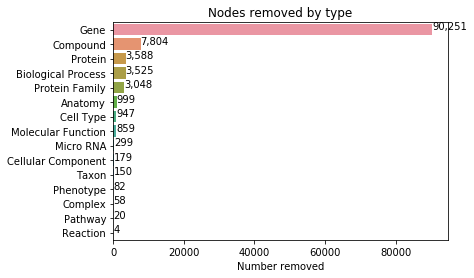

In [27]:
count_plot_h(nodes.query('id in @missing_nodes')['label'])
plt.title('Nodes removed by type')
plt.xlabel('Number removed');

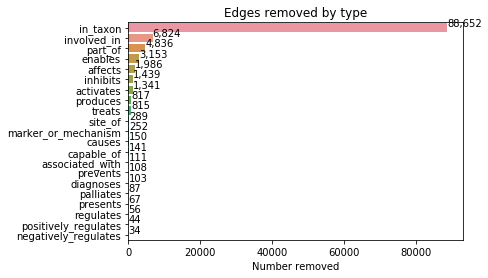

In [28]:
count_plot_h(edges.query('start_id in @missing_nodes or end_id in @missing_nodes')['type_no_abbv'])
plt.title('Edges removed by type')
plt.xlabel('Number removed');

#### Save network

In [29]:
this_name = '10_Semmantic_Compression'

out_dir = Path('../2_pipeline/').joinpath(this_name).joinpath('out').resolve()

out_dir.mkdir(parents=True, exist_ok=True)

nodes_prune.to_csv(out_dir.joinpath('nodes.csv'), index=False)
edges_prune.to_csv(out_dir.joinpath('edges.csv'), index=False)

## Map to biolink

In [30]:
label_to_biolink = biolink_map.set_index('hetnet')['bl_hierarchy_mapping'].to_dict()
node_abbrev_map = biolink_map.set_index('bl_hierarchy_mapping')['hie_abbrev'].to_dict()

nodes_prune['label'] = nodes_prune['label'].map(label_to_biolink)

In [31]:
# reset the edge semmantics
edges_prune['type'] = edges_prune['type_no_abbv']

# Add in the new abbrevations
edges_prune = add_abbrevs(nodes_prune, edges_prune, {**node_abbrev_map, **edge_abbrev_map}, directed_map)
edges_prune.head(2)

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p,source,license,experiments,support_type,pmids,phase,date,abbrev,type_no_abbv
0,CHEBI:10056,NCBIGene:1129,activates,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,CaG,activates
1,CHEBI:10056,NCBIGene:1131,activates,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,CaG,activates


In [32]:
edges_prune['abbrev'].nunique()

96

In [33]:
edges_prune['type_no_abbv'] = edges_prune['type']
edges_prune['type'] = edges_prune['type'] + '_' + edges_prune['abbrev']

In [34]:
edges_prune.head(2)

,start_id,end_id,type,dsrc_type,comp_type,p_val,adj_p,source,license,experiments,support_type,pmids,phase,date,abbrev,type_no_abbv
0,CHEBI:10056,NCBIGene:1129,activates_CaG,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,CaG,activates
1,CHEBI:10056,NCBIGene:1131,activates_CaG,computed,merge,NaN,NaN,WikiData,CC0 1.0,NaN,NaN,NaN,NaN,NaN,CaG,activates


### Ensure Biolink Mapping hasn't resulted in Reverse Types

For example, if we had `Gene` `part_of` `Cellular Component` and `Cellular Component` `has_part` `Protein`,  Mapping to biolkink would result in `AnatomicalEntity` `has_part` `MacromolecularMachine` and `MacromolecularMachine` `part_of` `AnatomicalEntity`, which are essentially the same edges just reversed.  These need to be normalized if identified.

In [35]:
combo = combine_nodes_and_edges(nodes_prune, edges_prune)
combo['rev_type'] = combo['type_no_abbv'].map(rev_map)

In [36]:
# Don't need to do these operations on the entire set of edges, just one of each type is ok
meta_edges = combo.drop_duplicates(subset=['start_label', 'type_no_abbv', 'end_label']).copy()

In [37]:
meta_edges['fwd_tup'] = meta_edges[['start_label', 'type_no_abbv', 'end_label']].apply(tuple, axis=1)
meta_edges['rev_tup'] = meta_edges[['end_label', 'rev_type', 'start_label']].apply(tuple, axis=1)

In [38]:
overlaps = list(set(meta_edges['fwd_tup']) & set(meta_edges['rev_tup']))
overlaps

[]

Empty list is exactly what we were looking for... Perfect!

## Save out

In [39]:
'{:,}'.format(len(nodes_prune))

'256,744'

In [40]:
'{:,}'.format(len(edges_prune))

'9,844,149'

In [41]:
ex = expand_col_on_char(edges_prune, 'source', '|')

In [42]:
ex['source'].value_counts()

CTD                         6276722
Gene Ontology               1461299
WikiData                    1139533
Reactome                     903330
Human Phenotype Ontology     223912
miRTarBase                    94610
Protein Ontology              76144
Inxight Drugs                 46728
GAUSS                         30004
ensembl                       26744
InterPro                      25200
DrugCentral                   10660
DrugBank                       9014
ensembel                       4307
ComplexPortal                  1999
Cell Ontology                   793
UBERON                          467
Name: source, dtype: int64

In [43]:
nodes_prune.to_csv(out_dir.joinpath('nodes_biolink.csv'), index=False)
edges_prune.to_csv(out_dir.joinpath('edges_biolink.csv'), index=False)